In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import datetime

import re
import string
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
import langid
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder


In [2]:
df = pd.read_csv('GTA_V.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             50000 non-null  int64  
 1   author                       50000 non-null  object 
 2   language                     50000 non-null  object 
 3   review                       49724 non-null  object 
 4   timestamp_created            50000 non-null  int64  
 5   timestamp_updated            50000 non-null  int64  
 6   voted_up                     50000 non-null  bool   
 7   votes_up                     50000 non-null  int64  
 8   votes_funny                  50000 non-null  int64  
 9   weighted_vote_score          50000 non-null  float64
 10  comment_count                50000 non-null  int64  
 11  steam_purchase               50000 non-null  bool   
 12  received_for_free            50000 non-null  bool   
 13  written_during_e

In [3]:
df['received_for_free'].value_counts(normalize=True)

0.000000    0.88504
0.523810    0.03918
0.476190    0.01320
0.521739    0.00426
0.478261    0.00188
             ...   
0.579176    0.00002
0.609912    0.00002
0.572380    0.00002
0.805616    0.00002
0.529747    0.00002
Name: weighted_vote_score, Length: 1212, dtype: float64

In [4]:
df['voted_up'].value_counts(normalize=True)


True     0.90082
False    0.09918
Name: voted_up, dtype: float64

In [5]:
df['weighted_vote_score'].value_counts(normalize=True)

0.000000    0.88504
0.523810    0.03918
0.476190    0.01320
0.521739    0.00426
0.478261    0.00188
             ...   
0.579176    0.00002
0.609912    0.00002
0.572380    0.00002
0.805616    0.00002
0.529747    0.00002
Name: weighted_vote_score, Length: 1212, dtype: float64

In [6]:
#Want key, values within Author column to be its own columns, so need to extract 
df['author'][0]

"{'steamid': '76561199217985175', 'num_games_owned': 16, 'num_reviews': 4, 'playtime_forever': 1809, 'playtime_last_two_weeks': 238, 'playtime_at_review': 1809, 'last_played': 1678462695}"

In [7]:
def extract_author_data(author_string):
    author_dict = eval(author_string)  # convert the string to a dictionary
    return author_dict

In [8]:
df['author_data'] = df['author'].apply(extract_author_data)


In [9]:
df = pd.concat([df.drop(['author_data'], axis=1), df['author_data'].apply(pd.Series)], axis=1)
df = df.drop(['author'], axis=1)

In [10]:
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,written_during_early_access,hidden_in_steam_china,steam_china_location,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
0,134422026,english,N word 😎😎,1678474766,1678474766,True,0,0,0.0,0,...,False,True,NaN,76561199217985175,16,4,1809,238,1809,1678462695
1,134422008,english,ggggaaaaaaaaanggggg\n\n,1678474749,1678474749,True,0,0,0.0,0,...,False,True,NaN,76561199406373367,6,3,186,186,183,1678474907
2,134421845,english,fun,1678474576,1678474576,True,0,0,0.0,0,...,False,True,NaN,76561199186246169,7,2,583,22,560,1678475969
3,134421764,english,GOOD,1678474476,1678474476,True,0,0,0.0,0,...,False,True,NaN,76561199232914042,77,7,406,10,406,1678468636
4,134420856,english,:)),1678473401,1678473401,True,0,0,0.0,0,...,False,True,NaN,76561199471446519,5,2,1857,530,1857,1678473398


In [11]:
df.drop(['steam_china_location'], axis=1, inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49724 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             49724 non-null  int64  
 1   language                     49724 non-null  object 
 2   review                       49724 non-null  object 
 3   timestamp_created            49724 non-null  int64  
 4   timestamp_updated            49724 non-null  int64  
 5   voted_up                     49724 non-null  bool   
 6   votes_up                     49724 non-null  int64  
 7   votes_funny                  49724 non-null  int64  
 8   weighted_vote_score          49724 non-null  float64
 9   comment_count                49724 non-null  int64  
 10  steam_purchase               49724 non-null  bool   
 11  received_for_free            49724 non-null  bool   
 12  written_during_early_access  49724 non-null  bool   
 13  hidden_in_steam_

In [12]:
df['num_games_owned'].describe()

count    49724.000000
mean        39.481176
std        126.697189
min          0.000000
25%          5.000000
50%         14.000000
75%         37.000000
max      16506.000000
Name: num_games_owned, dtype: float64

In [14]:
games_owned_outlier = df.loc[df['num_games_owned']== 16506.000000] # despite this record being an outlier for owned the review is real and needs to be kept 
print(games_owned_outlier.loc[22565, 'review'])

[h1]Introduction[/h1]
The embodiment of gaming's self-irony. Mocking corporate greed until you start showcasing that precise trait in real life. That is how Grand Theft Auto 5 can be summarised, at least as far as I'm concerned. 

Out of sheer boredom rather than explicit intention, I've decided to review a title I still hold in high regard even if it's starting to feel more and more like an excruciating, guilty pleasure with each passing year of its far prolonged "shelf life". 

[b]“You either die a hero or you live long enough to see yourself become the villain.”[/b]

The catalyst for this article was reading recently that GTA V has sold over 170 million units in nine years since release. I played it since day one, on the PS3 and 2013 now seems like a far cry from current world circumstances. 

I would lie if I claimed that I didn't have a boatload of fun within this condensed open world, yet I must warn you that I shall only  write about the singleplayer component which I have compl

In [19]:
# #Define function to convert a Unix timestamp to a datetime object
def unix_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)
df["last_played"] = df["last_played"].apply(unix_to_datetime)



In [21]:
df['last_played']

0       2023-03-10 10:38:15
1       2023-03-10 14:01:47
2       2023-03-10 14:19:29
3       2023-03-10 12:17:16
4       2023-03-10 13:36:38
                ...        
49995   2022-07-13 00:04:56
49996   2023-02-28 19:20:06
49997   2023-03-10 01:19:48
49998   2022-12-08 21:30:12
49999   2023-01-31 09:23:05
Name: last_played, Length: 49724, dtype: datetime64[ns]

In [22]:
df['comment_count'].value_counts(normalize=True) # Wont be needing this due to huge imbalance


0     0.986184
1     0.009875
2     0.001890
3     0.000825
4     0.000422
5     0.000201
7     0.000101
6     0.000080
8     0.000080
10    0.000080
15    0.000040
24    0.000020
31    0.000020
25    0.000020
11    0.000020
34    0.000020
13    0.000020
26    0.000020
28    0.000020
43    0.000020
36    0.000020
40    0.000020
Name: comment_count, dtype: float64

In [24]:
df.drop('comment_count', axis= 1, inplace = True)

In [23]:
df['playtime_forever'].value_counts(normalize=True)

601      0.000302
503      0.000282
1387     0.000282
970      0.000282
225      0.000261
           ...   
50088    0.000020
37414    0.000020
47392    0.000020
48505    0.000020
49095    0.000020
Name: playtime_forever, Length: 21748, dtype: float64

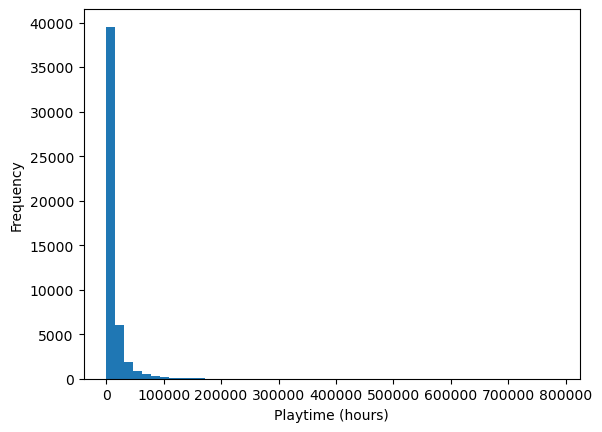

In [26]:
# plot a histogram with 50 bins
plt.hist(df['playtime_forever'], bins=50)
plt.xlabel('Playtime (hours)')
plt.ylabel('Frequency')
plt.show()

In [28]:
df['num_reviews'].describe()

count    49724.000000
mean         5.890194
std         13.956404
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1153.000000
Name: num_reviews, dtype: float64

In [29]:
df['num_games_owned'].describe()

count    49724.000000
mean        39.481176
std        126.697189
min          0.000000
25%          5.000000
50%         14.000000
75%         37.000000
max      16506.000000
Name: num_games_owned, dtype: float64

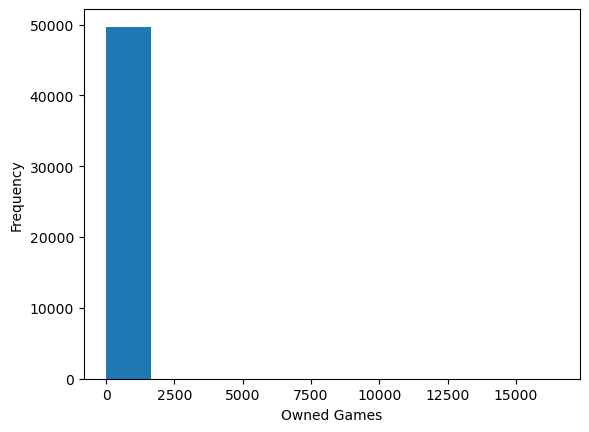

In [39]:
# plot a histogram with 50 bins
plt.hist(df['num_games_owned'])
plt.xlabel('Owned Games')
plt.ylabel('Frequency')
plt.show()

In [32]:
df['votes_funny'].value_counts(normalize=True)

0      0.971503
1      0.024153
2      0.002011
3      0.000362
6      0.000141
         ...   
94     0.000020
145    0.000020
100    0.000020
53     0.000020
162    0.000020
Name: votes_funny, Length: 62, dtype: float64

In [33]:
df['weighted_vote_score'].describe()

count    49724.000000
mean         0.059193
std          0.164829
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.940312
Name: weighted_vote_score, dtype: float64

In [40]:
df['num_reviews'].describe()

count    49724.000000
mean         5.890194
std         13.956404
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1153.000000
Name: num_reviews, dtype: float64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49724 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   recommendationid             49724 non-null  int64         
 1   language                     49724 non-null  object        
 2   review                       49724 non-null  object        
 3   timestamp_created            49724 non-null  int64         
 4   timestamp_updated            49724 non-null  int64         
 5   voted_up                     49724 non-null  bool          
 6   votes_up                     49724 non-null  int64         
 7   votes_funny                  49724 non-null  int64         
 8   weighted_vote_score          49724 non-null  float64       
 9   steam_purchase               49724 non-null  bool          
 10  received_for_free            49724 non-null  bool          
 11  written_during_early_access  49724 non-nu

In [41]:
df.drop(['language','votes_funny','weighted_vote_score','steam_purchase','received_for_free','written_during_early_access','hidden_in_steam_china','num_reviews','num_games_owned','playtime_last_two_weeks','playtime_at_review'], axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49724 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   recommendationid   49724 non-null  int64         
 1   review             49724 non-null  object        
 2   timestamp_created  49724 non-null  int64         
 3   timestamp_updated  49724 non-null  int64         
 4   voted_up           49724 non-null  bool          
 5   votes_up           49724 non-null  int64         
 6   steamid            49724 non-null  object        
 7   playtime_forever   49724 non-null  int64         
 8   last_played        49724 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(5), object(2)
memory usage: 3.5+ MB


### Preprocessing

In [ ]:
num_empty = df['preprocessed_text'].apply(lambda x: len(x) == 0).sum()
empty_rows = df[df['preprocessed_text'].apply(lambda x: len(x)) == 0].index

print(f"There are {num_empty} empty rows.")

In [ ]:
missing_tags = []
for doc in df['preprocessed_text']:
    for token in doc:
        if len(token) != 2:
            missing_tags.append(token)
            
if len(missing_tags) > 0:
    print("The following tokens are missing a POS tag:", missing_tags)
else:
    print("All tokens have a corresponding POS tag.")

In [ ]:
df = df.drop(empty_rows)
df.info()
df['preprocessed_text']

### Word frequency & wordcloud 


freq_dist = FreqDist(df["preprocessed_text"].explode())
fdist = {k[0]:v for k, v in freq_dist.items()}

# Get the top 20 most frequent words from the frequency distribution
top_words = freq_dist.most_common(20)

In [ ]:
# Extract the words and their frequencies as separate lists
words = [word[0][0] for word in top_words]
frequencies = [word[1] for word in top_words]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1, ax2 = axes.flatten()
ax1.bar(words, frequencies)
ax1.set_title("Frequency Distribution of Preprocessed Steam Reviews", fontsize=16)
ax1.set_xlabel("Words", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=12)

In [ ]:
# WordCloud
fdist = {k[0]: v for k, v in freq_dist.items()}
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(fdist)
ax2.imshow(wordcloud)
ax2.set_title("Word Cloud of Preprocessed Steam Reviews", fontsize=16)
ax2.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Reviews w.Playtime mean contribution as those users played the game more than average amount
df['playtime_forever'].describe()


Carlos you may want to use the below df for EDA... move below to before wordcloud, freqDist, eta

In [ ]:
playtime_mean = df['playtime_forever'].mean()
df_filtered = df[df['playtime_forever'] >= playtime_mean]
df_filtered.info()

In [ ]:
freq_dist_2 = FreqDist(df_filtered['preprocessed_text'].explode())
top_words_2= freq_dist_2.most_common(20)
words_2, freqs = zip(*top_words_2)
words = [w[0] for w in words_2]
plt.bar(words, freqs)
plt.xticks(rotation=90)
plt.show()


In [ ]:
#### Review of users that voted down comment
voted_down = df_filtered[df_filtered['voted_up']==False]
voted_down_freq = FreqDist(voted_down['preprocessed_text'].explode())
top_voted_down = voted_down_freq.most_common(20)
words_3, freqs_2 = zip(*top_voted_down)
words = [w[0] for w in words_3]
plt.bar(words, freqs_2)
plt.xticks(rotation=90)
plt.show()


In [ ]:
df['cleaned_text'] = df_filtered['preprocessed_text'].apply(lambda x: [word[0] for word in x])
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(df['cleaned_text'].sum())
finder.apply_freq_filter(5)  # filter out low-frequency bigrams
bigrams = finder.nbest(bigram_measures.raw_freq, 50)  # get top 50 bigrams by frequency
print(bigrams)
